# EVALUATION LOOP

In [1]:
# ------------------------------------------------------------
# 0.  Imports & config – nothing here should clash with yours
# ------------------------------------------------------------
from tqdm import tqdm
import torch
from mathbert_encoder import MathBERTEncoder
import retriever_cosine as rc
# from import retrieve_top_k_cosine, retrieve_sample_k_cosine
from response_sampler import sample_responses_per_demo
from reward_aggregator import compute_demo_accuracy
from icl_model_wrapper import OpenAIICLModel, OpenAIAdvanced
from grpo_optimizer import grpo_step
from datasets import load_dataset
from dotenv import load_dotenv
import os
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import helpers

reload(rc)

load_dotenv()

API_KEY = os.getenv("OPENAI_API_KEY")
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
K       = 1             # demos per query
NUM_SAMPLES = 1           # model completions per query
TEMPERATURE = 0.7           # keep same as training loop

# ------------------------------------------------------------
# 1.  Initialise encoder **in eval mode** (weights frozen)
# ------------------------------------------------------------
encoder = MathBERTEncoder(device=DEVICE, trainable=False)
encoder.eval()                                   # no grads!

icl_model = OpenAIAdvanced(api_key=API_KEY,
                           model_name="gpt-4.1-nano",
                           temperature=TEMPERATURE)

# ------------------------------------------------------------
# 2.  Load/define the inference set
#     If you already saved a slice elsewhere, just load it.
# ------------------------------------------------------------
train_path = "./data/MATH/train.jsonl"
train_ds_list = helpers.load_jsonl(train_path)[:40]
raw_demos = helpers.load_jsonl(train_path)[:256]

# ------------------------------------------------------------
# 3.  Evaluation loop
# ------------------------------------------------------------
total, correct = 0, 0
all_losses     = []          # optional – to compare prompt quality

# Build demo pool (everything except current query)

for idx in tqdm(range(len(train_ds_list)), desc="Baseline eval"):
    item       = train_ds_list[idx]
    Q_inf, A_gt, A_ans = item["problem"], item["solution"], item["answer"]
    demos = [(d["problem"], d["solution"], d["answer"])
                for j, d in enumerate(raw_demos) if j != idx]
        
    # Encode query + candidate demos
    with torch.no_grad():
        q_emb     = encoder.encode([Q_inf], detach=True).squeeze(0)
        demo_embs = encoder.encode([q for (q,_, _) in demos], detach=True)

    # ------- ORIGINAL cosine retrieval -------------------------
    top_k, _ = rc.retrieve_top_k_cosine(
        q_emb, demo_embs, k=min(K, len(demos))
    )
    print(f"🔍 Top-K Indices: {top_k}")
    selected_demos = [demos[i] for i in top_k]          # length = 2

    # ------- Run the ICL model --------------------------------
    responses_nested = sample_responses_per_demo(
        demo_tuples = selected_demos,
        Q_inf       = Q_inf,
        icl_model   = icl_model,
        num_samples = NUM_SAMPLES,
        parallel=True
    )
    flat_responses = [r for demo_resps in responses_nested for r in demo_resps]
    print("Solution: ", A_ans)
    print("Response: ", flat_responses[0])
    acc = compute_demo_accuracy(flat_responses, A_ans)
    print(acc) 
    correct += acc
    total   += 1

baseline_acc = correct / total
print(f"\n📊  Baseline accuracy on MATH500: {baseline_acc:.3%}")


Baseline eval:   0%|          | 0/40 [00:00<?, ?it/s]

🔍 Top-K Indices: [149]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:   2%|▎         | 1/40 [00:02<01:46,  2.73s/it]

Solution:  2
Response:  2
['2']
1.0
🔍 Top-K Indices: [104]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:   5%|▌         | 2/40 [00:04<01:32,  2.44s/it]

Solution:  18
Response:  18
['18']
1.0
🔍 Top-K Indices: [109]
[INFO] Launching 1 parallel inference tasks...
Solution:  \dfrac{7}{20}
Response:  \frac{1}{2}
['\\frac{1}{2}']


Baseline eval:   8%|▊         | 3/40 [00:10<02:29,  4.04s/it]

0.0
🔍 Top-K Indices: [159]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  10%|█         | 4/40 [00:13<02:01,  3.37s/it]

Solution:  1.36
Response:  \boxed{1.36}
['\\boxed{1.36}']
1.0
🔍 Top-K Indices: [113]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  12%|█▎        | 5/40 [00:20<02:50,  4.86s/it]

Solution:  28
Response:  676
['676']
0.0
🔍 Top-K Indices: [76]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  15%|█▌        | 6/40 [00:26<02:53,  5.10s/it]

Solution:  \frac{2 \sqrt{149}}{3}
Response:  \frac{2\sqrt{149}}{3}
['\\frac{2\\sqrt{149}}{3}']
1.0
🔍 Top-K Indices: [64]
[INFO] Launching 1 parallel inference tasks...
Solution:  3\sqrt{3}
Response:   rac{2bc \, \, 	ext{cos} \frac{A}{2}}{b+c} 

In triangle ABC, sides are: 
AB = AC = 14, BC = 26.
Using the Law of Cosines to find angle A:

cos A = \frac{b^2 + c^2 - a^2}{2bc} = \frac{14^2 + 14^2 - 26^2}{2 \times 14 \times 14} = \frac{196 + 196 - 676}{392} = \frac{-284}{392} = -\frac{71}{98}.

Now, the angle A:
A = \arccos \left(-\frac{71}{98}\right).

The angle bisector from A has length:

l_a = \frac{2bc \sin \frac{A}{2}}{b + c}.

Since b = c = 14, this simplifies to:

l_a = \frac{2 \times 14 \times 14 \sin \frac{A}{2}}{14 + 14} = \frac{392 \sin \frac{A}{2}}{28} = 14 \sin \frac{A}{2}.

Using the half-angle formula:

\sin \frac{A}{2} = \sqrt{\frac{1 - \cos A}{2}} = \sqrt{\frac{1 - (-\frac{71}{98})}{2}} = \sqrt{\frac{1 + \frac{71}{98}}{2}} = \sqrt{\frac{\frac{98}{98} + \frac{71}{98}}{2}}

Baseline eval:  18%|█▊        | 7/40 [00:35<03:29,  6.35s/it]

0.0
🔍 Top-K Indices: [204]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  20%|██        | 8/40 [00:38<02:52,  5.38s/it]

Solution:  10\sqrt{2}
Response:  10\sqrt{2}
['10\\sqrt{2}']
1.0
🔍 Top-K Indices: [72]
[INFO] Launching 1 parallel inference tasks...
Solution:  3\sqrt{2}
Response:  54
['54']


Baseline eval:  22%|██▎       | 9/40 [00:43<02:40,  5.17s/it]

0.0
🔍 Top-K Indices: [154]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  25%|██▌       | 10/40 [00:46<02:13,  4.46s/it]

Solution:  \text{June 20}
Response:  \textbf{June 20
['\\textbf{June 20']
1.0
🔍 Top-K Indices: [194]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  28%|██▊       | 11/40 [00:53<02:37,  5.44s/it]

Solution:  32736
Response:  32861
['32861']
0.0
🔍 Top-K Indices: [151]
[INFO] Launching 1 parallel inference tasks...
Solution:  735
Response:  $ (33 \times 21.95) + (33 \times 2.55) = 33 \times (21.95 + 2.55) = 33 \times 24.50 = \boxed{808.50}.
['$ (33 \\times 21.95) + (33 \\times 2.55) = 33 \\times (21.95 + 2.55) = 33 \\times 24.50 = \\boxed{808.50}.']


Baseline eval:  30%|███       | 12/40 [00:57<02:16,  4.89s/it]

0.0
🔍 Top-K Indices: [33]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  32%|███▎      | 13/40 [01:02<02:16,  5.07s/it]

Solution:  5
Response:  5
['5']
1.0
🔍 Top-K Indices: [62]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  35%|███▌      | 14/40 [01:04<01:47,  4.13s/it]

Solution:  2
Response:  2
['2']
1.0
🔍 Top-K Indices: [109]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  38%|███▊      | 15/40 [01:12<02:06,  5.04s/it]

Solution:  5
Response:  5
['5']
1.0
🔍 Top-K Indices: [241]
[INFO] Launching 1 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=2048, prompt_tokens=407, total_tokens=2455, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=2048, prompt_tokens=407, total_tokens=2455, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was

Baseline eval:  40%|████      | 16/40 [01:57<06:54, 17.27s/it]

Turning text into JSON by brute force...
Solution:  \frac{416}{27}
Response:  \frac{416}{27}
['\\frac{416}{27}']
1.0
🔍 Top-K Indices: [192]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  42%|████▎     | 17/40 [02:01<05:01, 13.09s/it]

Solution:  19
Response:  19
['19']
1.0
🔍 Top-K Indices: [126]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  45%|████▌     | 18/40 [02:03<03:37,  9.90s/it]

Solution:  27
Response:  27
['27']
1.0
🔍 Top-K Indices: [192]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  48%|████▊     | 19/40 [02:06<02:44,  7.85s/it]

Solution:  50
Response:  50
['50']
1.0
🔍 Top-K Indices: [41]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  50%|█████     | 20/40 [02:10<02:11,  6.57s/it]

Solution:  \text{even}
Response:  even
['even']
1.0
🔍 Top-K Indices: [45]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  52%|█████▎    | 21/40 [02:15<01:55,  6.07s/it]

Solution:  \sqrt{10}
Response:  \sqrt{10}
['\\sqrt{10}']
1.0
🔍 Top-K Indices: [222]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  55%|█████▌    | 22/40 [02:17<01:30,  5.05s/it]

Solution:  4
Response:  4
['4']
1.0
🔍 Top-K Indices: [229]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  57%|█████▊    | 23/40 [02:21<01:18,  4.62s/it]

Solution:  \frac{2}{3}
Response:  \frac{2}{3}
['\\frac{2}{3}']
1.0
🔍 Top-K Indices: [115]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  60%|██████    | 24/40 [02:24<01:05,  4.11s/it]

Solution:  15
Response:  15
['15']
1.0
🔍 Top-K Indices: [123]
[INFO] Launching 1 parallel inference tasks...
Solution:  336
Response:  \( 8 \times 7 \times 6 = 336 \)
['\\( 8 \\times 7 \\times 6 = 336 \\)']


Baseline eval:  62%|██████▎   | 25/40 [02:27<00:55,  3.69s/it]

0.0
🔍 Top-K Indices: [5]
[INFO] Launching 1 parallel inference tasks...
Solution:  \frac{1}{5}, -\frac{1}{3}
Response:  -\frac{1}{3}
['-\\frac{1}{3}']


Baseline eval:  65%|██████▌   | 26/40 [02:32<00:58,  4.21s/it]

0.0
🔍 Top-K Indices: [16]
[INFO] Launching 1 parallel inference tasks...
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=2048, prompt_tokens=387, total_tokens=2435, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=2048, prompt_tokens=387, total_tokens=2435, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))
False
Error making OpenAI API call: Could not parse response content as the length limit was reached - CompletionUsage(comple

Baseline eval:  68%|██████▊   | 27/40 [03:05<02:48, 12.95s/it]

Turning text into JSON by brute force...
Solution:  11
Response:  11
['11']
1.0
🔍 Top-K Indices: [112]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  70%|███████   | 28/40 [03:09<02:02, 10.23s/it]

Solution:  \begin{pmatrix} 8 & 12 \\ -4 & 20 \end{pmatrix}
Response:  \\begin{pmatrix} 8 & 12 \\ -4 & 20 \\end{pmatrix}
['\\\\begin{pmatrix} 8 & 12 \\\\ -4 & 20 \\\\end{pmatrix}']
1.0
🔍 Top-K Indices: [229]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  72%|███████▎  | 29/40 [03:13<01:32,  8.45s/it]

Solution:  11
Response:  12
['12']
0.0
🔍 Top-K Indices: [79]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  75%|███████▌  | 30/40 [03:16<01:07,  6.75s/it]

Solution:  0
Response:  0
['0']
1.0
🔍 Top-K Indices: [243]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  78%|███████▊  | 31/40 [03:19<00:49,  5.53s/it]

Solution:  4
Response:  4
['4']
1.0
🔍 Top-K Indices: [33]
[INFO] Launching 1 parallel inference tasks...
Solution:  18\text{ ways.}
Response:  $12$
['$12$']


Baseline eval:  80%|████████  | 32/40 [03:22<00:38,  4.80s/it]

0.0
🔍 Top-K Indices: [97]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  82%|████████▎ | 33/40 [03:24<00:28,  4.05s/it]

Solution:  9
Response:  9
['9']
1.0
🔍 Top-K Indices: [36]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  85%|████████▌ | 34/40 [03:27<00:21,  3.66s/it]

Solution:  \frac{i}{5}
Response:  z = \frac{i}{5}
['z = \\frac{i}{5}']
1.0
🔍 Top-K Indices: [48]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  88%|████████▊ | 35/40 [03:30<00:16,  3.37s/it]

Solution:  90
Response:  90
['90']
1.0
🔍 Top-K Indices: [41]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  90%|█████████ | 36/40 [03:33<00:12,  3.19s/it]

Solution:  y^4-2y^3+7y^2+y-5
Response:  $y^4 - 2y^3 + 7y^2 + y - 5$
['$y^4 - 2y^3 + 7y^2 + y - 5$']
1.0
🔍 Top-K Indices: [166]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  92%|█████████▎| 37/40 [03:35<00:08,  2.91s/it]

Solution:  120
Response:  \boxed{120}
['\\boxed{120}']
1.0
🔍 Top-K Indices: [33]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  95%|█████████▌| 38/40 [03:37<00:05,  2.77s/it]

Solution:  20
Response:  20
['20']
1.0
🔍 Top-K Indices: [26]
[INFO] Launching 1 parallel inference tasks...


Baseline eval:  98%|█████████▊| 39/40 [03:40<00:02,  2.62s/it]

Solution:  400
Response:  400
['400']
1.0
🔍 Top-K Indices: [96]
[INFO] Launching 1 parallel inference tasks...


Baseline eval: 100%|██████████| 40/40 [03:42<00:00,  5.57s/it]

Solution:  2
Response:  2
['2']
1.0

📊  Baseline accuracy on MATH500: 75.000%


In [ ]:
import helpers
train_path = "./data/MATH/train.jsonl"
train_ds_list = helpers.load_jsonl(train_path)
print(train_ds_list[0])

{'problem': 'How many vertical asymptotes does the graph of $y=\\frac{2}{x^2+x-6}$ have?', 'solution': 'The denominator of the rational function factors into $x^2+x-6=(x-2)(x+3)$. Since the numerator is always nonzero, there is a vertical asymptote whenever the denominator is $0$, which occurs for $x = 2$ and $x = -3$.  Therefore, the graph has $\\boxed{2}$ vertical asymptotes.', 'answer': '2', 'subject': 'Algebra', 'level': 3, 'unique_id': 'test/algebra/1.json'}


# TRAINING LOOP

In [1]:
from tqdm import tqdm
import torch
import helpers
from mathbert_encoder import MathBERTEncoder
import retriever_cosine as rc
# from import retrieve_top_k_cosine, retrieve_sample_k_cosine
from response_sampler import sample_responses_per_demo
from reward_aggregator import compute_demo_accuracy
from icl_model_wrapper import OpenAIICLModel, OpenAIAdvanced
from grpo_optimizer import grpo_step
from datasets import load_dataset
from dotenv import load_dotenv
import os
from transformers import get_linear_schedule_with_warmup
from importlib import reload

reload(rc)

load_dotenv()

# === Settings ===
API_KEY = os.getenv("OPENAI_API_KEY")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
K = 10
NUM_SAMPLES_PER_DEMO = 4
LEARNING_RATE =  5e-5
MAX_STEPS = 15
TEMPERATURE = 0.1

# === Init ===
encoder = MathBERTEncoder(device=DEVICE, trainable=True)
encoder.train()

icl_model = OpenAIAdvanced(api_key=API_KEY,
                           model_name="gpt-4.1-nano",
                           temperature=TEMPERATURE)
optimizer = torch.optim.Adam(encoder.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
WARMUP_STEPS = 3 # Define number of warmup steps for the scheduler

# Initialize the Learning Rate Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=MAX_STEPS
)
train_path = "./data/MATH/train.jsonl"
all_examples = helpers.load_jsonl(train_path)
train_ds_list = all_examples[:20]
raw_demos = all_examples[:128]

# === Training Loop ===
reward_history = []
N = len(train_ds_list)
active_indices = list(range(N))

for step in range(MAX_STEPS):
    print(f"\n=== Training Step {step+1} ===")
    epoch_rewards = [None] * N                # default to None for every example
    next_active = []

    # loop only over the “hard” examples
    for idx in tqdm(active_indices, desc="Examples"):
        item = train_ds_list[idx]
        Q_inf, A_gt, A_ans = item["problem"], item["solution"], item["answer"]

        # --- encode & retrieve as before ---
        q_emb = encoder.encode([Q_inf], detach=False).squeeze(0)
        demo_pool = [d for j, d in enumerate(raw_demos) if j != idx]
        demo_questions = [d["problem"] for d in demo_pool]
        demo_embs = encoder.batched_encode(demo_questions, batch_size=16, detach=False)
        top_k_inds, sims = rc.retrieve_top_k_cosine(q_emb, demo_embs, k=min(K, len(demo_questions)))
        
        top_k_inds_adj = [i if i < idx else i + 1 for i in top_k_inds]
        print("-------Question---------")
        print(Q_inf)
        print(f"\n🧠 Inference Index {idx}")
        print(f"🔍 Top-K Indices: {top_k_inds_adj}")
        top_k_inds, sims = rc.retrieve_sample_k_cosine(q_emb, demo_embs, k=min(K, len(demo_questions)), tau=0.01)
        top_k_inds_adj = [i.item() if i.item() < idx else i.item() + 1 for i in top_k_inds]
        print(f"❗ Sampled Indices: {top_k_inds_adj}")
        
        

        selected = [(raw_demos[i], i) for i in top_k_inds_adj]
        # Remember the demo_q's that was selected here. 
        
        # --- sample responses & compute mean reward ---
        responses_nested = sample_responses_per_demo(
            demo_tuples=[(d[0]["problem"], d[0]["solution"], d[0]["answer"],d[1]) for d in selected],
            Q_inf=Q_inf,
            icl_model=icl_model,
            num_samples=NUM_SAMPLES_PER_DEMO,
            parallel=True
        )
        print("Responses_nested:", responses_nested)
        rewards = []
        print("Responses: ", responses_nested)
        for i, responses in enumerate(responses_nested):
            reward = compute_demo_accuracy(responses, A_ans)
            rewards.append(reward)
            # print(f"    Demo {i} | Reward: {reward:.2f}")
        
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        print("Rewards tensor:", rewards)
        print("Sims tensor:", sims)
        loss = grpo_step(
            rewards,
            sims,
            q_emb,
            demo_embs,
            optimizer
        )
        scheduler.step()

        mean_r = rewards.mean().item()
        epoch_rewards[idx] = mean_r

        # decide whether to keep for next epoch
        if mean_r <= 0.75:
            next_active.append(idx)

        print(f"✅  idx={idx} | Mean Reward: {mean_r:.4f} | Loss: {loss:.4f}")

    # record this epoch’s full reward vector (with Nones)
    reward_history.append(epoch_rewards)

    dropped = len(active_indices) - len(next_active)
    print(f"Epoch {step+1}: dropped {dropped} examples (mean_r > 0.75).")
    active_indices = next_active

    if not active_indices:
        print("All examples have converged—stopping early.")
        break




=== Training Step 1 ===


Examples:   0%|          | 0/20 [00:00<?, ?it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f0212547e90>>
Traceback (most recent call last):
  File "/home/josephL/miniconda3/envs/unsloth/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 23.59 GiB of which 3.94 MiB is free. Process 2894398 has 21.09 GiB memory in use. Including non-PyTorch memory, this process has 2.29 GiB memory in use. Of the allocated memory 1.92 GiB is allocated by PyTorch, and 67.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

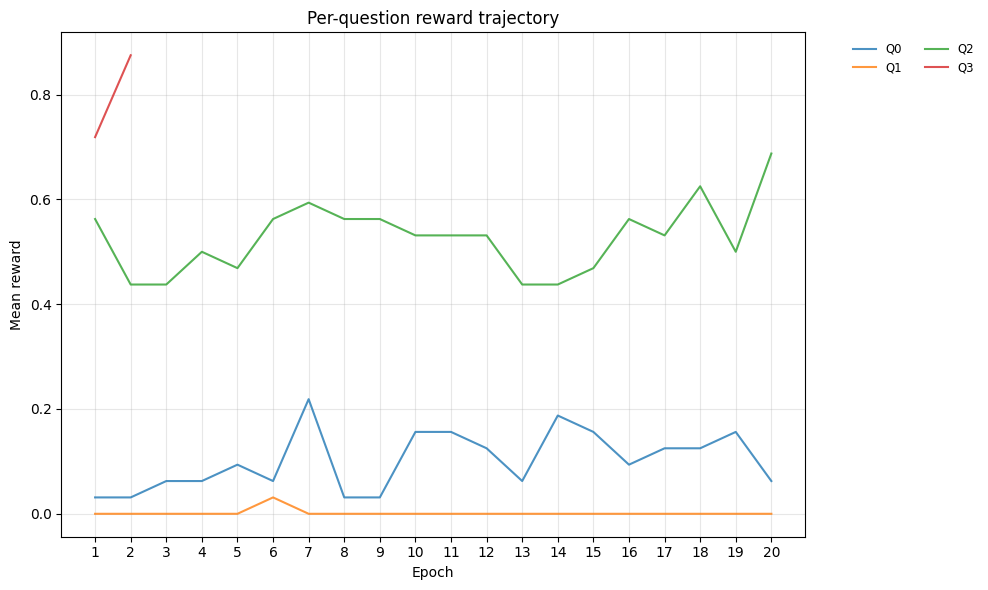

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --- reshape rewards ---
# epoch_wide_rewards  -> shape (num_epochs, num_questions)
epoch_wide_rewards = [[item for item in rewards] for rewards in reward_history]
reward_matrix = np.array(epoch_wide_rewards)       # (E, Q)
num_epochs, num_qs = reward_matrix.shape

# --- plot ---
plt.figure(figsize=(10, 6))
x = np.arange(1, num_epochs + 1)

for q in range(num_qs):
    plt.plot(x, reward_matrix[:, q], label=f"Q{q}", alpha=0.8)

plt.title("Per-question reward trajectory")
plt.xlabel("Epoch")
plt.ylabel("Mean reward")
plt.xticks(x)
plt.grid(alpha=0.3)

# put the legend outside so the graph isn’t cluttered
plt.legend(
    bbox_to_anchor=(1.05, 1), loc="upper left",
    ncol=2, fontsize="small", frameon=False
)

plt.tight_layout()
plt.show()

In [5]:
import numpy as np

# -------------------------------------------------
# 1.  Build a (E, Q) array from reward_history
# -------------------------------------------------
reward_matrix = np.asarray([[v for v in row] for row in reward_history],
                           dtype=object)         # keep Nones intact

# -------------------------------------------------
# 2.  Convert to float, using NaN for missing values
# -------------------------------------------------
rm_float = np.full_like(reward_matrix, np.nan, dtype=float)
for i in range(rm_float.shape[0]):
    for j in range(rm_float.shape[1]):
        v = reward_matrix[i, j]
        rm_float[i, j] = np.nan if v is None else float(v)

# -------------------------------------------------
# 3.  Count slopes
# -------------------------------------------------
pos, neg, flat = 0, 0, 0

for q in range(rm_float.shape[1]):
    col = rm_float[:, q]
    idx = np.where(~np.isnan(col))[0]            # finite rows
    if len(idx) < 2:                             # need ≥2 points
        flat += 1
        continue

    first, last = col[idx[0]], col[idx[-1]]
    if last > first:
        pos += 1
    elif last < first:
        neg += 1
    else:
        flat += 1

print(f"Positive-sloping lines: {pos}")
print(f"Negative-sloping lines: {neg}")
print(f"Flat / insufficient data: {flat}")

Positive-sloping lines: 4
Negative-sloping lines: 5
Flat / insufficient data: 31


In [ ]:
# ------------------------------------------------------------
# 0.  Imports & config – nothing here should clash with yours
# ------------------------------------------------------------
from tqdm import tqdm
import torch
from mathbert_encoder import MathBERTEncoder
import retriever_cosine as rc
# from import retrieve_top_k_cosine, retrieve_sample_k_cosine
from response_sampler import sample_responses_per_demo
from reward_aggregator import compute_demo_accuracy
from icl_model_wrapper import OpenAIICLModel
from grpo_optimizer import grpo_step
from datasets import load_dataset
from dotenv import load_dotenv
import os
from transformers import get_linear_schedule_with_warmup
from importlib import reload

reload(rc)

load_dotenv()

API_KEY = os.getenv("OPENAI_API_KEY")
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
K       = 3                # demos per query
NUM_SAMPLES = 5             # model completions per query
TEMPERATURE = 0.7           # keep same as training loop

# ------------------------------------------------------------
# 1.  Initialise encoder **in eval mode** (weights frozen)
# ------------------------------------------------------------
encoder.eval()                                   # no grads!

icl_model = OpenAIICLModel(api_key=API_KEY,
                           model_name="gpt-4.1-nano",
                           temperature=TEMPERATURE)

# ------------------------------------------------------------
# 2.  Load/define the inference set
#     If you already saved a slice elsewhere, just load it.
# ------------------------------------------------------------
gsm8k_data = load_dataset("gsm8k", "main")["train"].select(range(256))  # slice first 200 examples
gsm8k_to_infer = load_dataset("gsm8k", "main")["train"] \
                     .select(range(20))          # ⬅ change as needed

# ------------------------------------------------------------
# 3.  Evaluation loop
# ------------------------------------------------------------
total, correct = 0, 0
all_losses     = []          # optional – to compare prompt quality

for idx in tqdm(range(len(gsm8k_to_infer)), desc="Baseline eval"):
    item       = gsm8k_to_infer[idx]
    Q_inf, A_gt = item["question"], item["answer"]

    # Build demo pool (everything except current query)
    demos = [(d["question"], d["answer"])
             for j, d in enumerate(gsm8k_data) if j != idx]

    # Encode query + candidate demos
    with torch.no_grad():
        q_emb     = encoder.encode([Q_inf], detach=True).squeeze(0)
        demo_embs = encoder.encode([q for (q, _) in demos], detach=True)

    # ------- ORIGINAL cosine retrieval -------------------------
    top_k, _ = rc.retrieve_top_k_cosine(
        q_emb, demo_embs, k=min(K, len(demos))
    )
    print(f"🔍 Top-K Indices: {top_k}")
    selected_demos = [demos[i] for i in top_k]          # length = 2

    # ------- Run the ICL model --------------------------------
    responses_nested = sample_responses_per_demo(
        demo_tuples = selected_demos,
        Q_inf       = Q_inf,
        icl_model   = icl_model,
        num_samples = NUM_SAMPLES,
        parallel=True
    )
    print(responses_nested)
    flat_responses = [r for demo_resps in responses_nested for r in demo_resps]
    acc = compute_demo_accuracy(flat_responses, A_gt)
    print(acc) 
    correct += acc
    total   += 1

baseline_acc = correct / total
print(f"\n📊  Baseline accuracy on GSM8K_to_infer: {baseline_acc:.3%}")


Baseline eval:   0%|          | 0/20 [00:00<?, ?it/s]

🔍 Top-K Indices: [78, 79, 211]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:   5%|▌         | 1/20 [00:01<00:22,  1.17s/it]

[['48 + (48/2) = 48 + 24 = 72', '48 + (48 / 2) = 48 + 24 = 72', '48 + (48 ÷ 2) = 48 + 24 = 72', '48 + (48/2) = 48 + 24 = 72', '48 + (48 ÷ 2) = 48 + 24 = 72'], ['48 + 24 = 72', '72', '48 + 48/2 = 48 + 24 = 72', '48 + (48/2) = 48 + 24 = 72', '144'], ['48 + 24 = 72', '48 + (48/2) = 48 + 24 = 72', '48 + 24 = 72', '72', '72']]
0.9333333333333333
🔍 Top-K Indices: [63, 119, 81]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  10%|█         | 2/20 [00:02<00:23,  1.32s/it]

[['10', '10', '10', '10', '10'], ['10', '10', '10', '10', '10'], ['10', '10', '10', '10', '10']]
1.0
🔍 Top-K Indices: [13, 82, 11]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  15%|█▌        | 3/20 [00:03<00:22,  1.30s/it]

[['55', '55', '55', '55', '55'], ['25', '53', '53', '50', '53'], ['55', '70', '55', '55', '55']]
0.9333333333333333
🔍 Top-K Indices: [130, 136, 229]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  20%|██        | 4/20 [00:05<00:19,  1.25s/it]

[['48', '54', '48', '48', '54'], ['60', '60', '60', '60', '60'], ['48', '48', '48', '48', '48']]
0.0
🔍 Top-K Indices: [63, 119, 140]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  25%|██▌       | 5/20 [00:06<00:19,  1.27s/it]

[['312', '312', '312', '312', '312'], ['312', '312', '312', '312', '312'], ['312', '312', '312', '312', '312']]
0.0
🔍 Top-K Indices: [135, 105, 41]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  30%|███       | 6/20 [00:07<00:19,  1.39s/it]

[['130', '110', '110', 'Total yellow flowers = 10  \nPurple flowers = 80% more than yellow = 10 + 0.80 * 10 = 10 + 8 = 18  \nTotal yellow and purple = 10 + 18 = 28  \nGreen flowers = 25% of yellow and purple = 0.25 * 28 = 7  \nTotal flowers = yellow + purple + green = 10 + 18 + 7 = 35', 'Total yellow flowers = 10  \nPurple flowers = 80% more than yellow = 10 + 0.80 * 10 = 10 + 8 = 18  \nTotal yellow and purple = 10 + 18 = 28  \nGreen flowers = 25% of yellow and purple = 0.25 * 28 = 7  \nTotal flowers = yellow + purple + green = 10 + 18 + 7 = 35'], ['Yellow: 10\nPurple: 80% more than yellow = 10 * 1.8 = 18\nYellow + purple: 10 + 18 = 28\nGreen: 25% of yellow + purple = 0.25 * 28 = 7\nTotal flowers: 10 + 18 + 7 = 35', 'Yellow = 10  \nPurple = 80% more than yellow = 10 + 0.8 * 10 = 10 + 8 = 18  \nTotal yellow and purple = 10 + 18 = 28  \nGreen = 25% of yellow and purple = 0.25 * 28 = 7  \nTotal flowers = yellow + purple + green = 10 + 18 + 7 = 35', 'Yellow: 10  \nPurple: 80% more than yel

Baseline eval:  35%|███▌      | 7/20 [00:09<00:18,  1.39s/it]

[['48', '48', '48', '48', '48'], ['48', '48', '48', '48', '48'], ['48', '48', '48', '48', '48']]
1.0
🔍 Top-K Indices: [91, 18, 17]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  40%|████      | 8/20 [00:10<00:16,  1.38s/it]

[['16', '16', '8', '8', '8'], ['8', '10', '8', '16', '16'], ['8', '16', '16', '16', '16']]
0.5333333333333333
🔍 Top-K Indices: [85, 94, 173]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  45%|████▌     | 9/20 [00:12<00:15,  1.43s/it]

[['41', '41', '41', '61', '61'], ['$41', '$41', '$41', '87', '$41'], ['87', '87', '$41', '$41', '$41']]
0.6666666666666666
🔍 Top-K Indices: [119, 18, 63]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  50%|█████     | 10/20 [00:13<00:13,  1.36s/it]

[['$495', '$405', '$405', '$585', '$405'], ['$270', '90', '$405', '$270', '10*1.5*18=270  \n270*5=1350'], ['$495', '$405', '$495', '$495', '540']]
0.06666666666666667
🔍 Top-K Indices: [223, 42, 142]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  55%|█████▌    | 11/20 [00:15<00:13,  1.45s/it]

[['4', '42', '42', '422', '1'], ['423.5', '422', '423.5', '1', '423'], ['423.5', '423.5', '423.5', '423.5', '423.5']]
0.13333333333333333
🔍 Top-K Indices: [105, 85, 49]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  60%|██████    | 12/20 [00:16<00:11,  1.45s/it]

[['2', '2', '7', "4 lawns x $15 = $60; total money saved = $95 - $15 (change) = $80; money from mowing = $60; remaining money for shoveling = $80 - $60 = $20; shoveling earns $7 each; number of driveways = $20 / $7 ≈ 2.86; since he can't shovel a fraction of a driveway, he must have shoveled 2 driveways.", "4 lawns x $15 = $60  \nTotal money saved before buying shoes = $95 + $15 (change) = $110  \nTotal money from mowing lawns = $60  \nMoney from shoveling driveways = $110 - $60 = $50  \nNumber of driveways shoveled = $50 / $7 ≈ 7.14  \nSince he can't shovel a fraction of a driveway, he shovels 7 driveways"], ['4', '4', '4', '4', '4'], ['3', '5', '4', '4', '10']]
0.2
🔍 Top-K Indices: [5, 211, 82]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  65%|██████▌   | 13/20 [00:18<00:10,  1.46s/it]

[['55', '80', '55', '55', '55'], ['60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (1/2 * 60 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + ( (1/2) * 60 - 5 ) = 60 + (30 - 5) = 60 + 25 = 85', '60 + (60/2 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '60 + ( (1/2) * 60 - 5 ) = 60 + (30 - 5) = 60 + 25 = 85'], ['75', '75', '60 + (1/2 * 60 - 5) = 60 + (30 - 5) = 60 + 25 = 85', '75', '75']]
0.4
🔍 Top-K Indices: [241, 48, 117]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  70%|███████   | 14/20 [00:19<00:08,  1.39s/it]

[['$30', '$30', '$40', '$30', '$40'], ['$34', '$10 + $5 + $20 = 35', '$30', '$10 + $5 + $20 = 35', '$40'], ['$20', '$26', '$36', '$34', '$34']]
0.13333333333333333
🔍 Top-K Indices: [2, 3, 130]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  75%|███████▌  | 15/20 [00:20<00:06,  1.35s/it]

[['3', '120 / 8 = 15 (sets of 8 pages)\n15 * 20 = 300 minutes\n300 / 60 = 5 hours', '120 / 8 = 15 (number of 20-minute segments needed)\n15 * 20 minutes = 300 minutes\n300 / 60 = 5 hours', '120 / 8 = 15 (number of reading sessions needed)\n15 * 20 = 300 minutes\n300 / 60 = 5 hours', '120 / 8 = 15  \n15 * 20 = 300 minutes  \n300 / 60 = 5 hours'], ['3', '20/8 = 2.5 minutes per page  \n120 * 2.5 = 300 minutes  \n300 / 60 = 5 hours', '3', '3', '20 minutes / 8 pages = 2.5 minutes per page  \n120 pages × 2.5 minutes = 300 minutes  \n300 minutes ÷ 60 = 5 hours'], ['3', '3', '3', '3', '3']]
0.4
🔍 Top-K Indices: [81, 63, 197]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  80%|████████  | 16/20 [00:23<00:07,  1.87s/it]

[['6000', '15000', '15000', '37500', '35000'], ['30000', '$90000', 'Profit per DVD = 2.5 * 6 - 6 = 15 - 6 = 9  \nNumber of DVDs sold in 20 weeks = 500 DVDs/day * 5 days/week * 20 weeks = 500 * 5 * 20 = 50,000  \nTotal profit = 50,000 * 9 = 450,000', '75000', 'Profit per DVD = 6 * 2.5 - 6 = 15 - 6 = 9  \nNumber of DVDs sold in 20 weeks = 500 * 5 * 20 = 50,000  \nTotal profit = 50,000 * 9 = 450,000'], ['$15000', '$132,000', '$22,500', '$15,000', '$7,500']]
0.0
🔍 Top-K Indices: [66, 145, 81]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  85%|████████▌ | 17/20 [00:25<00:05,  1.77s/it]

[['1000', '1000', '$1000', '1000', '$1000'], ['200', "Mike's share = (2/5) * 2500 = 1000  \nMoney left after buying the shirt = 1000 - 200 = 800", "Mike's share = (2 / (2 + 5)) * 2500 = (2 / 7) * 2500 ≈ 714.2857  \nMoney Mike has after buying the shirt = 714.2857 - 200 ≈ 514.2857  \nFinal answer: 514", "Mike's share = (2/5) × 2500 = 1000  \nRemaining after buying the shirt = 1000 - 200 = 800  \nAnswer: 800", "Mike's share is (2/7) of total profit, and Johnson's share is (5/7) of total profit.\n\nJohnson's share = $2500 = (5/7) of total profit  \nTotal profit = $2500 * (7/5) = $2500 * 1.4 = $3500\n\nMike's share = (2/7) of total profit = (2/7) * $3500 = $1000\n\nAfter buying the shirt for $200, Mike has:  \n$1000 - $200 = $800\n\n800"], ['1000', '1000', '714.29', '1000', '1000']]
0.2
🔍 Top-K Indices: [82, 156, 182]
[INFO] Launching 15 parallel inference tasks...


Baseline eval:  90%|█████████ | 18/20 [00:27<00:03,  1.81s/it]

[['47', '53', '73', '53', '33'], ['49', '55', '61', '55', '49'], ['53', '49', '26 - 4 = 22 pink hard hats remaining\nJohn takes away 6 pink hard hats and twice as many green hard hats as the pink hard hats he took, so green hard hats taken by John = 2 * 6 = 12\nRemaining pink hard hats = 22 - 6 = 16\nRemaining green hard hats = 15 - 12 = 3\nRemaining yellow hard hats = 24 (none taken)\nTotal remaining hard hats = 16 + 3 + 24 = 43', '26 + 15 + 24 = 65\nCarl takes away 4 pink hard hats: remaining pink = 26 - 4 = 22\nJohn takes away 6 pink hard hats: remaining pink = 22 - 6 = 16\nJohn takes away twice as many green hard hats as pink hard hats he removed: 2 * 6 = 12 green hard hats\nRemaining green hard hats = 15 - 12 = 3\nTotal remaining hard hats = pink + green + yellow = 16 + 3 + 24 = 43', "26 - 4 = 22 (pink hard hats remaining after Carl's removal)  \nJohn takes away 6 pink hard hats, leaving 22 - 6 = 16 pink hard hats in the truck  \nJohn takes away twice as many green hard hats as th

Baseline eval:  95%|█████████▌| 19/20 [00:28<00:01,  1.65s/it]

[['9', '9', '9', '10', '9'], ['9', '9', '9', '9', '9'], ['9', '9', '9', '9', '9']]
0.0
🔍 Top-K Indices: [18, 119, 15]
[INFO] Launching 15 parallel inference tasks...


Baseline eval: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]

[['10', '10', '8', '9', '16'], ['8', '8', '8', '8', '8'], ['16', '16', '16', '16', '20 miles each way, so 40 miles per day for 5 days: 40*5=200 miles  \nWeekend ride: 200 miles  \nTotal miles: 200+200=400 miles  \nTime = Distance / Speed = 400 / 25 = 16 hours']]
0.4

📊  Baseline accuracy on GSM8K_to_infer: 38.333%


In [ ]:
# Save the updated MathBERT model
save_path = "./10k_q4_128_demos_0.1_temp_20_max_steps_on_MATH500_mathbert"  # your save directory
encoder.model.save_pretrained(save_path)
encoder.tokenizer.save_pretrained(save_path)

# LOADING

# from transformers import BertTokenizer, BertModel

# model = BertModel.from_pretrained("./updated_mathbert")
# tokenizer = BertTokenizer.from_pretrained("./updated_mathbert")



('./53k_q3_1024_demos_0.7_temp_40_max_steps_temp_mathbert/tokenizer_config.json',
 './53k_q3_1024_demos_0.7_temp_40_max_steps_temp_mathbert/special_tokens_map.json',
 './53k_q3_1024_demos_0.7_temp_40_max_steps_temp_mathbert/vocab.txt',
 './53k_q3_1024_demos_0.7_temp_40_max_steps_temp_mathbert/added_tokens.json')